In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import numpy as np
import pandas as pd
import tensorflow.keras.backend as K
from tensorflow import keras
import matplotlib.pyplot as plt
# from tensorflow.keras import layers
from sklearn import preprocessing
import mlflow
import socket
import json
import pickle
from sklearn.metrics import classification_report, confusion_matrix

# from udp_req import udp_send, udp_server


MODEL_PORT = 10652
DATA_PORT = 10653

FILE_NAME = "re_train.txt"
DATA_TMP = "re_rec.txt"
ORIGIN_DATA = 'CMAPSSData/train_FD001.txt'
TEST_DATA = 'CMAPSSData/test_FD001.txt'
RUL_FILE = "CMAPSSData/RUL_FD001.txt"
TIME_OUT = 3
MODEL_NAME = "regression_test"
REMAIN_NUM = 35



In [2]:
ORIGIN_DATA = 'CMAPSSData/train_FD001.txt'
TEST_DATA = 'CMAPSSData/test_FD004.txt'
RUL_FILE = "CMAPSSData/RUL_FD004.txt"

In [3]:
fd001 = pd.read_csv('CMAPSSData/test_FD001.txt', sep=" ",header=None)
fd001.drop(fd001.columns[[26,27]],axis=1,inplace=True)
fd001.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                    's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                    's15', 's16', 's17', 's18', 's19', 's20', 's21']

fd004 = pd.read_csv('CMAPSSData/test_FD004.txt', sep=" ",header=None)
fd004.drop(fd004.columns[[26,27]],axis=1,inplace=True)
fd004.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                    's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                    's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [17]:
fd001_rul = pd.DataFrame(fd001.groupby('id')['cycle'].max()).reset_index()
fd001_rul.columns = ['id', 'max']
fd001_truth = pd.read_csv("CMAPSSData/RUL_FD001.txt", sep=" ", header=None)
fd001_truth.drop(fd001_truth.columns[[1]], axis=1, inplace=True)
fd001_truth.columns = ['more']
fd001_truth['id'] = fd001_truth.index + 1
fd001_truth['max'] = fd001_rul['max'] + fd001_truth['more']
fd001_truth.drop('more', axis=1, inplace=True)
fd001 = fd001.merge(fd001_truth, on=['id'], how='left')
fd001['RUL'] = fd001['max'] - fd001['cycle']
fd001.loc[fd001['RUL']>=130,'RUL'] = 130
fd001.drop('max', axis=1, inplace=True)
fd001['label1'] = np.where(fd001['RUL'] <= 30, 1, 0 )
tmp_drop_id = [drop_id for drop_id in fd001['id'].unique() if fd001[fd001['id']==drop_id].shape[0]<=25]
fd001 = fd001[~fd001['id'].isin(tmp_drop_id)]


fd004_rul = pd.DataFrame(fd004.groupby('id')['cycle'].max()).reset_index()
fd004_rul.columns = ['id', 'max']
fd004_truth = pd.read_csv("CMAPSSData/RUL_FD004.txt", sep=" ", header=None)
fd004_truth.drop(fd004_truth.columns[[1]], axis=1, inplace=True)
fd004_truth.columns = ['more']
fd004_truth['id'] = fd004_truth.index + 1
fd004_truth['max'] = fd004_rul['max'] + fd004_truth['more']
fd004_truth.drop('more', axis=1, inplace=True)
fd004 = fd004.merge(fd004_truth, on=['id'], how='left')
fd004['RUL'] = fd004['max'] - fd004['cycle']
fd004.loc[fd004['RUL']>=130,'RUL'] = 130
fd004.drop('max', axis=1, inplace=True)
fd004['label1'] = np.where(fd004['RUL'] <= 30, 1, 0 )
tmp_drop_id = [drop_id for drop_id in fd004['id'].unique() if fd004[fd004['id']==drop_id].shape[0]<=25]
fd004 = fd004[~fd004['id'].isin(tmp_drop_id)]

In [12]:
tmp_drop_id = [drop_id for drop_id in fd004['id'].unique() if fd004[fd004['id']==drop_id].shape[0]<=25]

In [13]:
tmp_drop_id

[10, 19, 28, 125, 141, 204, 229]

In [18]:
scaler = preprocessing.MinMaxScaler()
scaler_column = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                    's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                    's15', 's16', 's17', 's18', 's19', 's20', 's21']
for col in scaler_column:
    fd001[[col]] = scaler.fit_transform(fd001[[col]])
    fd004[[col]] = scaler.fit_transform(fd004[[col]])

# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3','cycle']
sequence_cols.extend(sensor_cols)

In [19]:
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means
    we need to drop those which are below the window-length. """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    if(num_elements > seq_length):
        for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
            yield data_array[start:stop, :]

# function to generate label_array
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [20]:
fd001_seq_gen = (list(gen_sequence(fd001[fd001['id']==id], 25, sequence_cols)) 
        for id in fd001['id'].unique())

fd004_seq_gen = (list(gen_sequence(fd004[fd004['id']==id], 25, sequence_cols)) 
        for id in fd004['id'].unique())

In [21]:
fd001_seq_array = np.concatenate(list(fd001_seq_gen)).astype(np.float32)

In [22]:
fd004_seq_array = np.concatenate(list(fd004_seq_gen)).astype(np.float32)

In [32]:
fd001.head(-5)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1
0,1,1,0.65625,0.692308,0.0,0.0,0.596215,0.421968,0.282214,0.0,...,0.152259,0.347076,0.0,0.375,0.0,0.0,0.500000,0.620099,130,0
1,1,2,0.34375,0.230769,0.0,0.0,0.182965,0.504025,0.225240,0.0,...,0.277907,0.227709,0.0,0.500,0.0,0.0,0.645455,0.645718,130,0
2,1,3,0.53125,0.538462,0.0,0.0,0.419558,0.464814,0.346130,0.0,...,0.192892,0.533557,0.0,0.500,0.0,0.0,0.700000,0.681104,130,0
3,1,4,0.77500,0.461538,0.0,0.0,0.413249,0.391587,0.449867,0.0,...,0.217896,0.282359,0.0,0.250,0.0,0.0,0.627273,0.620382,130,0
4,1,5,0.60000,0.461538,0.0,0.0,0.435331,0.471306,0.357974,0.0,...,0.187891,0.337009,0.0,0.125,0.0,0.0,0.618182,0.676008,130,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13086,100,189,0.49375,0.615385,0.0,0.0,0.681388,0.604778,0.679396,0.0,...,0.904983,0.524928,0.0,0.500,0.0,0.0,0.363636,0.542675,29,1
13087,100,190,0.27500,0.615385,0.0,0.0,0.574132,0.777201,0.753318,0.0,...,0.888105,0.688878,0.0,0.750,0.0,0.0,0.390909,0.594055,28,1
13088,100,191,0.31875,0.384615,0.0,0.0,0.564669,0.532329,0.597509,0.0,...,0.834435,0.742570,0.0,0.875,0.0,0.0,0.527273,0.414013,27,1
13089,100,192,0.30000,0.538462,0.0,0.0,0.605678,0.756687,0.698183,0.0,...,0.908555,0.404123,0.0,0.750,0.0,0.0,0.418182,0.395471,26,1


In [33]:
fd004.head(-5)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1
0,1,1,0.476271,0.831354,1.0,0.626985,0.656561,0.654027,0.501557,0.507937,...,0.574006,0.362211,0.0,0.631579,0.864693,1.0,0.478320,0.483780,130,0
1,1,2,0.595087,0.736342,0.0,0.238089,0.007372,0.041486,0.016265,0.293184,...,0.039366,0.945325,0.0,0.042105,0.000000,0.0,0.141260,0.137380,130,0
2,1,3,0.999810,1.000000,1.0,0.000000,0.127258,0.270191,0.200168,0.000000,...,0.637839,0.423747,0.0,0.273684,0.627907,1.0,0.006775,0.016466,130,0
3,1,4,0.999893,0.997862,1.0,0.000000,0.126889,0.269020,0.203579,0.000000,...,0.660202,0.410736,0.0,0.273684,0.627907,1.0,0.012534,0.005168,130,0
4,1,5,0.833363,0.997625,1.0,0.060269,0.181349,0.305358,0.229632,0.146592,...,0.599510,0.390686,0.0,0.326316,0.651163,1.0,0.157859,0.157613,130,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41204,248,272,0.476176,0.831354,1.0,0.626985,0.667895,0.687097,0.573586,0.507937,...,0.669049,0.370707,0.0,0.673684,0.864693,1.0,0.479336,0.478967,35,0
41205,248,273,0.476219,0.831354,1.0,0.626985,0.669093,0.671978,0.592520,0.507937,...,0.671441,0.378351,0.0,0.673684,0.864693,1.0,0.479675,0.477062,34,0
41206,248,274,0.238024,0.298456,1.0,0.597937,0.640435,0.720492,0.724293,0.617180,...,0.897781,0.173658,1.0,0.726316,0.854123,1.0,0.612466,0.611643,33,0
41207,248,275,0.999893,0.998219,1.0,0.000000,0.137578,0.319196,0.266611,0.000000,...,0.751441,0.423498,0.0,0.315789,0.627907,1.0,0.018970,0.006904,32,0


In [2]:
def reload_model(model_name:str, model_version:str = None) -> mlflow.pyfunc.PyFuncModel:
    '''
    The models are stored in the MLflow tracking server.
    Fetch the latest model
    '''
    if model_version:
        model = mlflow.pyfunc.load_model(
            model_uri=f"models:/{model_name}/{model_version}"
        )
    else:
        model = mlflow.pyfunc.load_model(
            model_uri=f"models:/{model_name}/Production"
        )
    return model


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def single_train(x_train,y_train):
    client = mlflow.tracking.MlflowClient()
    mlflow.set_experiment("Regression Evaluate")

    i_shape = [25, 25]

    # y_train = keras.utils.to_categorical(label, num_classes)
    with mlflow.start_run() as run:
        run_id = run.info.run_id
        mlflow.tensorflow.autolog(log_models=True, disable=False, registered_model_name=None)
        model = keras.Sequential(
            [
                keras.layers.LSTM(32,return_sequences=True,activation='tanh',input_shape=i_shape),
                keras.layers.LSTM(64,return_sequences=True,activation='tanh'),
                keras.layers.LSTM(32,return_sequences=False,activation='tanh'),
                keras.layers.Dense(100, activation="relu"),
                keras.layers.Dropout(0.5),
                keras.layers.Dense(1,activation='linear')
            ]
        )

        batch_size = 128
        epochs = 20

        model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
        model.summary()

        history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.05)
        # mlflow.sklearn.log_model(model,"model")
        # score = model.evaluate(x_test, y_test, verbose=0)
        # score = -history.history['accuracy'][-1]
    result = mlflow.register_model(
        f"runs:/{run_id}/model",
        MODEL_NAME
    )
    # Get the latest model version
    latest_version = int(result.version)
    client.update_model_version(
        name=MODEL_NAME,
        version=latest_version,
        description='None'

    )
    # Transition the latest model to Production stage, others to Archived stage
    client.transition_model_version_stage(
        name=MODEL_NAME,
        version= latest_version,
        stage='Production',
        archive_existing_versions=True
    )
    return latest_version


# function to reshape features into seq_array: (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means
    we need to drop those which are below the window-length. """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

# function to generate label_array
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

def data_load(file_name:str = FILE_NAME, sequence_length=25, model_test:bool = False):
    # Read data from txt file
    train_df = pd.read_csv(file_name, sep=" ",header=None)
    # print('latest machine: ',np.sort(train_df[0].unique())[::1][0])
    train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
    train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                        's15', 's16', 's17', 's18', 's19', 's20', 's21']
    # Generate labels. If RUL < trashold, label = 1, o.w 0
    rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    if model_test:
        truth_df = pd.read_csv(RUL_FILE, sep=" ", header=None)
        truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
        truth_df.columns = ['more']
        truth_df['id'] = truth_df.index + 1
        truth_df['max'] = rul['max'] + truth_df['more']
        truth_df.drop('more', axis=1, inplace=True)
    else:
        truth_df = rul

    train_df = train_df.merge(truth_df, on=['id'], how='left')

    train_df['RUL'] = train_df['max'] - train_df['cycle']
    train_df.loc[train_df['RUL']>=130,'RUL'] = 130
    train_df.drop('max', axis=1, inplace=True)

    # generate label1 column for training data
    train_df['label1'] = np.where(train_df['RUL'] <= 30, 1, 0 )
    # Normalize the data
    scaler = preprocessing.MinMaxScaler()
    scaler_column = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                        's15', 's16', 's17', 's18', 's19', 's20', 's21']
    for col in scaler_column:
        train_df[[col]] = scaler.fit_transform(train_df[[col]])
    
    # pick the feature columns 
    sensor_cols = ['s' + str(i) for i in range(1,22)]
    sequence_cols = ['setting1', 'setting2', 'setting3','cycle']
    sequence_cols.extend(sensor_cols)
    # generator for the training sequences
    seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
            for id in train_df['id'].unique())
    # generate sequences and convert to numpy array
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

    # generate labels (generated from "RUL" col as it's RUL regression)
    label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
                for id in train_df['id'].unique()]
    rul_array = np.concatenate(label_gen).astype(np.float32)
    # generate labels (generated from "label1" col as its binary classification)
    label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
                for id in train_df['id'].unique()]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return seq_array, rul_array, label_array

def update_data(train_data:pd.DataFrame):
    # get latest machine id
    tmp_idx = np.sort(train_data[0].unique())[::-1][:REMAIN_NUM]
    # update file
    train_data.loc[train_data[0].isin(tmp_idx)].to_csv(FILE_NAME, sep=' ', header=False,index=False)

def model_train():
    x_train, y_train = data_load(file_name=ORIGIN_DATA)
    model_version = single_train(x_train, y_train)
    print(f"Training completed. The latest model version is: {model_version}")

def model_eva():
    model = mlflow.pyfunc.load_model(
        model_uri=f"models:/{MODEL_NAME}/Production"
    )
    mse = keras.losses.MeanSquaredError()
    testdata, testlabel = data_load(file_name=TEST_DATA,model_test=True)
    # testdata, testlabel = data_load(file_name=ORIGIN_DATA)

    label_pre = model.predict(testdata)[:,0]

    result_rmse = root_mean_squared_error(testlabel,label_pre)
    result_mse = mse(testlabel,label_pre)
    pre_rmse = 'RMSE is:' + str(result_rmse.numpy()) + '\n' + 'MSE is:' + str(result_mse.numpy()) + '\n'
    print(pre_rmse)


In [2]:
mlflow.set_tracking_uri("http://localhost:5000")
client = mlflow.tracking.MlflowClient()

In [27]:
client.delete_model_version(name='loss35_classification_cnn',version='1')

In [11]:
client.delete_registered_model(name='FD004_loss55_regression_cnn')

In [17]:
client.transition_model_version_stage(name='loss45_classification_lstm',version='66',stage='Production',archive_existing_versions=True)

<ModelVersion: creation_timestamp=1680695125624, current_stage='Production', description='None', last_updated_timestamp=1680700882543, name='loss45_classification_lstm', run_id='d3644fac4fd4494a99a48722590f62ac', run_link='', source='/home/lwh/nfsroot/mlruns/1/d3644fac4fd4494a99a48722590f62ac/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='66'>

In [41]:
client.rename_registered_model(name='loss35_classification_cnn',new_name='loss35_regression_cnn')

In [5]:
train_data, train_rul, train_label = data_load(ORIGIN_DATA)
test_data, test_rul, test_label = data_load(file_name=TEST_DATA,model_test=True)

## Evaluate the trained model
loss rate: [0%, 5%, 10%, 15%, 20%, 25%, 50%]

In [3]:
'''
Load pre-generate data
'''
loss_rate = ["loss0_","loss5_","loss10_","loss15_","loss20_","loss25_","loss30_","loss35_","loss40_","loss45_","loss50_","loss55_","loss60_","loss65_","loss70_","loss75_"]
model_type = ["classification_","regression_"]
algo_type = ["dnn","cnn","lstm","bilstm"]

result_dic = {}
ave_regression = {}

for tmp_model in model_type:
    for tmp_loss in loss_rate:
        for tmp_algo in algo_type:
            tmp_key = tmp_loss + tmp_model + tmp_algo
            tmp_file = 'result/FD001/' + tmp_key + '.p'
            result_dic[tmp_key] = pickle.load(open(tmp_file,'rb'))
            if tmp_model == "regression_":
                ave_regression[tmp_key] = np.mean(result_dic[tmp_key],axis=0)

### Evaluate Classification model

In [6]:
all_acc = {}
ave_acc = {}

all_conf = {}
ave_conf = {}
for tmp_key in result_dic.keys():
    if 'classification' in tmp_key:
        all_acc[tmp_key] = []
        all_conf[tmp_key] = []
        for tmp_pre in result_dic[tmp_key]:
            tmp_pre_cl = (tmp_pre>0.5).astype(np.int64)[:,-1]

            accuracy = np.sum(tmp_pre_cl==test_label) / tmp_pre_cl.shape[0]
            tmp_conf = confusion_matrix(test_label,tmp_pre_cl,normalize='pred')

            all_acc[tmp_key].append(accuracy)
            all_conf[tmp_key].append(tmp_conf)

        ave_acc[tmp_key] = np.mean(all_acc[tmp_key])
        ave_conf[tmp_key] = np.mean(all_conf[tmp_key],axis=0)

In [7]:
ave_acc

{'loss0_classification_dnn': 0.8809356303693789,
 'loss0_classification_cnn': 0.8938693274763491,
 'loss0_classification_lstm': 0.9296804397314022,
 'loss0_classification_bilstm': 0.9058006451834312,
 'loss5_classification_dnn': 0.8881138680119428,
 'loss5_classification_cnn': 0.91331348593523,
 'loss5_classification_lstm': 0.9283691959229898,
 'loss5_classification_bilstm': 0.9029597200858673,
 'loss10_classification_dnn': 0.8796286763444182,
 'loss10_classification_cnn': 0.9138840271343103,
 'loss10_classification_lstm': 0.9369559124655387,
 'loss10_classification_bilstm': 0.9028335449626503,
 'loss15_classification_dnn': 0.8881596257020945,
 'loss15_classification_cnn': 0.9079112186416829,
 'loss15_classification_lstm': 0.9336070215175539,
 'loss15_classification_bilstm': 0.9016324055961655,
 'loss20_classification_dnn': 0.8947129848885229,
 'loss20_classification_cnn': 0.9098802292460277,
 'loss20_classification_lstm': 0.9376980450026883,
 'loss20_classification_bilstm': 0.90462667

In [8]:
ave_conf['loss70_classification_dnn']

array([[0.98748507, 0.69753383],
       [0.01251493, 0.24186011]])

### Evaluate regression model

In [9]:
'''
Calculate RMSE
'''
all_rmse = {}
ave_rmse = {}
for tmp_key in result_dic.keys():
    if 'regression' in tmp_key:
        all_rmse[tmp_key] = []
        if 'dnn' in tmp_key or 'cnn' in tmp_key:
            for tmp_pre in result_dic[tmp_key]:
                all_rmse[tmp_key].append(root_mean_squared_error(test_rul, tmp_pre[:,-1]).numpy())
        else:
            for tmp_pre in result_dic[tmp_key]:
                all_rmse[tmp_key].append(root_mean_squared_error(test_rul, tmp_pre).numpy())
        # print(all_rmse)
        ave_rmse[tmp_key] = np.mean(all_rmse[tmp_key])

In [10]:
ave_rmse

{'loss0_regression_dnn': 34.524643,
 'loss0_regression_cnn': 33.481163,
 'loss0_regression_lstm': 31.198624,
 'loss0_regression_bilstm': 32.139427,
 'loss5_regression_dnn': 34.137245,
 'loss5_regression_cnn': 32.31173,
 'loss5_regression_lstm': 30.298983,
 'loss5_regression_bilstm': 31.462467,
 'loss10_regression_dnn': 32.731037,
 'loss10_regression_cnn': 31.575354,
 'loss10_regression_lstm': 30.26227,
 'loss10_regression_bilstm': 30.49685,
 'loss15_regression_dnn': 34.78817,
 'loss15_regression_cnn': 32.957394,
 'loss15_regression_lstm': 30.763224,
 'loss15_regression_bilstm': 31.589666,
 'loss20_regression_dnn': 35.095722,
 'loss20_regression_cnn': 34.32384,
 'loss20_regression_lstm': 30.33299,
 'loss20_regression_bilstm': 31.35654,
 'loss25_regression_dnn': 34.946285,
 'loss25_regression_cnn': 34.24014,
 'loss25_regression_lstm': 31.408333,
 'loss25_regression_bilstm': 31.796682,
 'loss30_regression_dnn': 36.153038,
 'loss30_regression_cnn': 34.91217,
 'loss30_regression_lstm': 32.5

In [11]:
# dnn_rsme = [ave_rmse['loss0_regression_dnn'],ave_rmse['loss5_regression_dnn'],ave_rmse['loss10_regression_dnn'],ave_rmse['loss15_regression_dnn'],ave_rmse['loss20_regression_dnn'],ave_rmse['loss25_regression_dnn'],ave_rmse['loss30_regression_dnn'],\
#             ave_rmse['loss35_regression_dnn'],ave_rmse['loss40_regression_dnn'],ave_rmse['loss45_regression_dnn'],ave_rmse['loss50_regression_dnn'],ave_rmse['loss55_regression_dnn'],ave_rmse['loss60_regression_dnn'],ave_rmse['loss65_regression_dnn'],\
#             ave_rmse['loss70_regression_dnn'],ave_rmse['loss75_regression_dnn']]
# cnn_rsme = [ave_rmse['loss0_regression_cnn'],ave_rmse['loss5_regression_cnn'],ave_rmse['loss10_regression_cnn'],ave_rmse['loss15_regression_cnn'],ave_rmse['loss20_regression_cnn'],ave_rmse['loss25_regression_cnn'],ave_rmse['loss50_regression_cnn'],\
#             ave_rmse['loss55_regression_cnn'],ave_rmse['loss60_regression_cnn'],ave_rmse['loss65_regression_cnn'],ave_rmse['loss70_regression_cnn'],ave_rmse['loss75_regression_cnn']]
# lstm_rsme = [ave_rmse['loss0_regression_lstm'],ave_rmse['loss5_regression_lstm'],ave_rmse['loss10_regression_lstm'],ave_rmse['loss15_regression_lstm'],ave_rmse['loss20_regression_lstm'],ave_rmse['loss25_regression_lstm'],ave_rmse['loss50_regression_lstm'],\
#              ave_rmse['loss55_regression_lstm'],ave_rmse['loss60_regression_lstm'],ave_rmse['loss65_regression_lstm'],ave_rmse['loss70_regression_lstm'],ave_rmse['loss75_regression_lstm']]
# bilstm_rsme = [ave_rmse['loss0_regression_bilstm'],ave_rmse['loss5_regression_bilstm'],ave_rmse['loss10_regression_bilstm'],ave_rmse['loss15_regression_bilstm'],ave_rmse['loss20_regression_bilstm'],ave_rmse['loss25_regression_bilstm'],ave_rmse['loss50_regression_bilstm']]

dnn_rsme = [ave_rmse['loss'+ str(i) +'_regression_dnn'] for i in range(0,80,5)]
cnn_rsme = [ave_rmse['loss'+ str(i) +'_regression_cnn'] for i in range(0,80,5)]
lstm_rsme = [ave_rmse['loss'+ str(i) +'_regression_lstm'] for i in range(0,80,5)]
bilstm_rsme = [ave_rmse['loss'+ str(i) +'_regression_bilstm'] for i in range(0,80,5)]

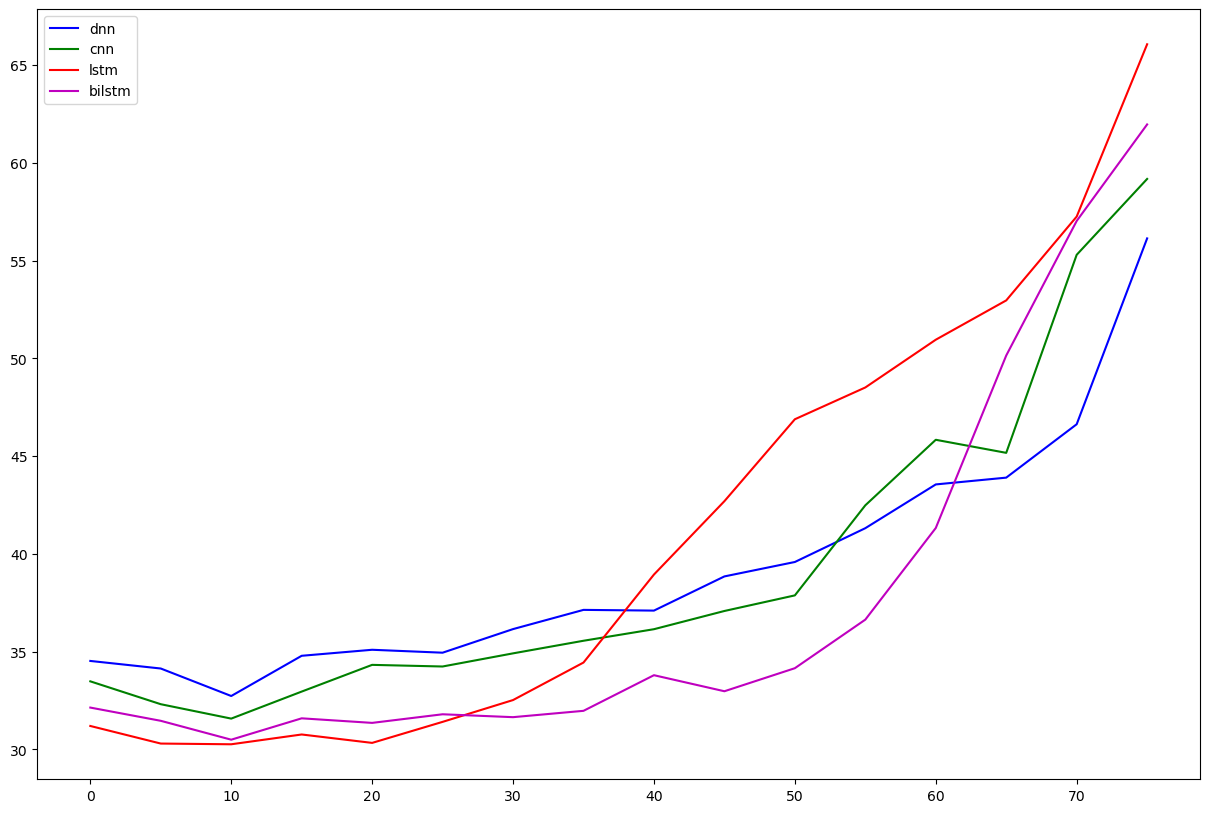

In [13]:
x_axes = np.arange(0,80,5)
plt.figure(figsize=(15,10))
plt.plot(x_axes,dnn_rsme,'b',label='dnn')
plt.plot(x_axes,cnn_rsme,'g',label='cnn')
plt.plot(x_axes,lstm_rsme,'r',label='lstm')
plt.plot(x_axes,bilstm_rsme,'m',label='bilstm')
plt.legend()

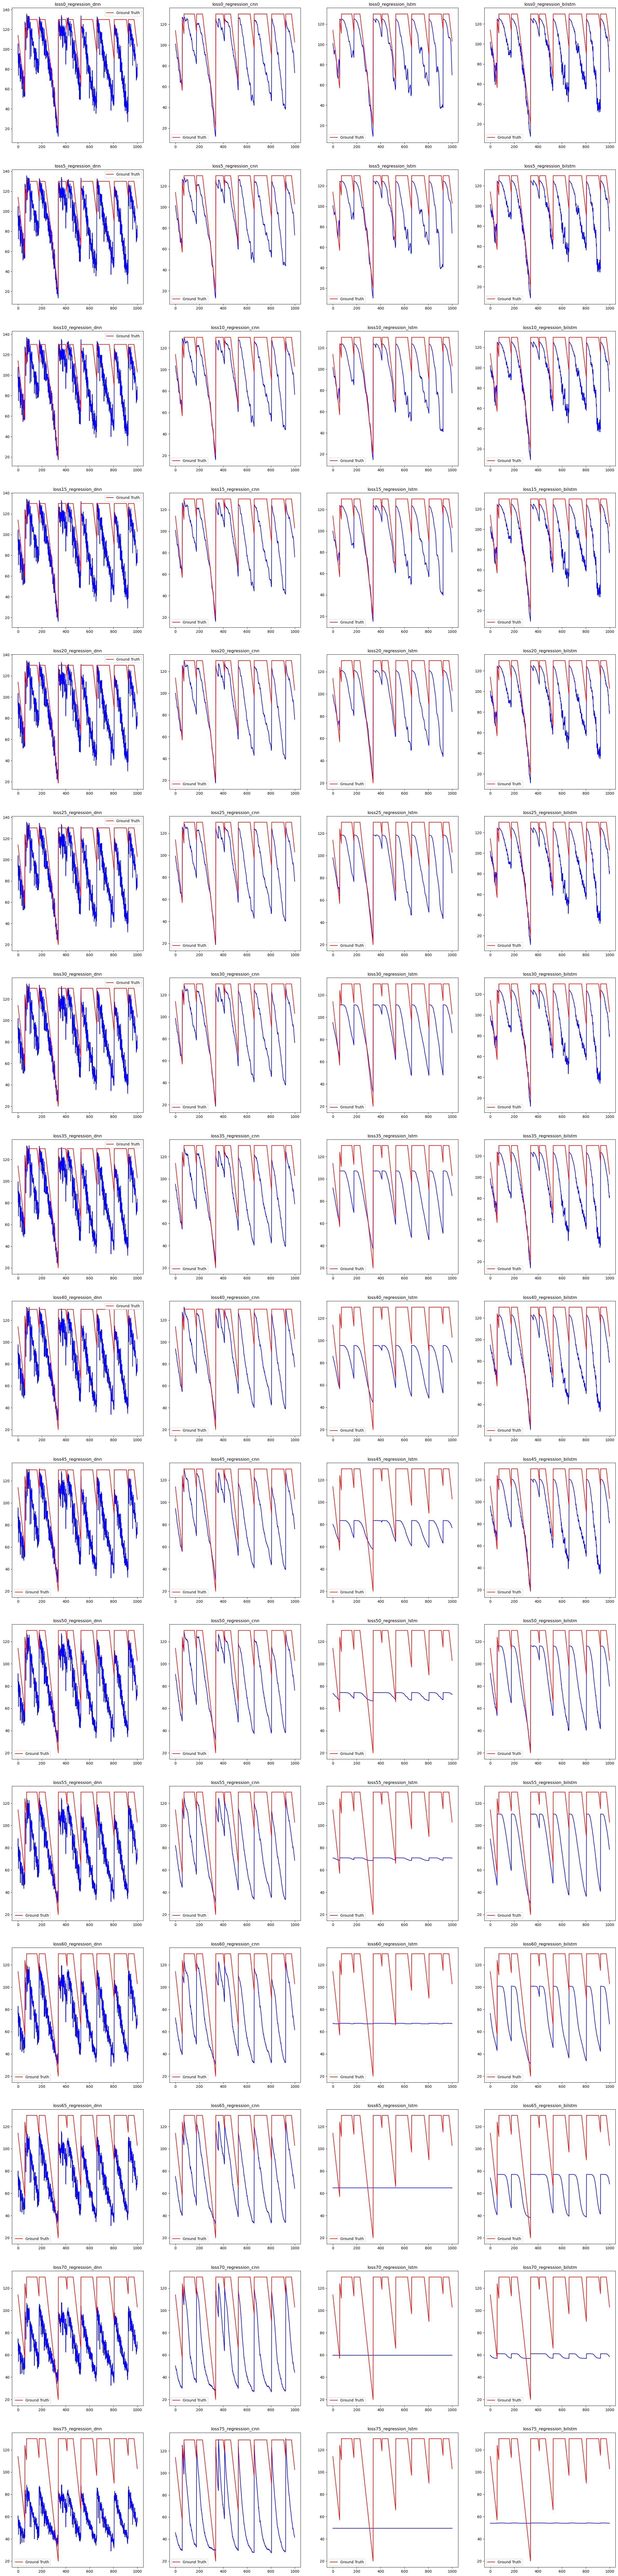

In [14]:
'''
Plot all the regression data
'''
fig, axes = plt.subplots(16,4, figsize=(30,128))
axes = axes.flatten()

for tmp_key, ax in zip(ave_regression.keys(), axes):
    ax.plot(np.arange(1000),ave_regression[tmp_key][:,-1][2000:3000],'b')
    ax.plot(np.arange(1000),test_rul[2000:3000],'r',label='Ground Truth')
    ax.legend()
    ax.set_title(tmp_key)
